<small><i>Updated February 2024 - This notebook was created by [Santi Seguí](https://ssegui.github.io/). </i></small>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## Lesson 5: Collaborative-based recommender systems: Factorization MODELS

Matrix factorization is a simple embedding model, which decomposes the user-item intraction matrix, $R \in R^{m\times n}$ matrix, where $m$ is the number of users and $n$ the number of items, into the product of two lower dimensionality rectangular matrice. The the goal of the factorization models is to learn:
* A user embedding (or user latent factor) $P \in R^{m\times k}$, where row $i$ is the embedding of user $i$.
* A item embedding (or item latent factor) $Q \in R^{n\times k}$, where row $j$ is the embedding of user $j$.

![alt factorization models](https://miro.medium.com/max/988/1*nIVWl2ROaxOY23hHajkTTg.png)

These methods became really popular due to the shown efficiency in the Netflix Prize Challenge. 

There are several variants of these methods:
* SVD 
* Vanilla Factorization Matrix (also knwon as Funk SVD)
* Vanilla Factorization Matrix with biases 
* SVD++
* ...

In these notewook we will the application of these method to the MovieLens dataset.

In [2]:
from tqdm import tqdm

In [3]:
def evaluate(predict_f,data_train,data_test):
    """ RMSE-based predictive performance evaluation with pandas. """
    ids_to_estimate = zip(data_test.user_id, data_test.movie_id)
    list_users = set(data_train.user_id)
    estimated = np.array([predict_f(u,i) if u in list_users else 3 for (u,i) in ids_to_estimate ])
    real = data_test.rating.values
    return compute_rmse(estimated, real)

def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

def precision(recommended_items, relevant_items):
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):  
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

## Divide the data in two sets: training and test
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.loc[sampled_ids, 'for_testing'] = True
    return df

def evaluate_algorithm_top(test, recommender_object, at=25, thr_relevant = 0.85):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0


    for user_id in tqdm(test.user_id.unique()):
        
        relevant_items = test[test.user_id==user_id]
        thr = np.quantile(relevant_items.rating,thr_relevant)
        relevant_items = np.array(relevant_items[relevant_items.rating >=thr].movie_id.values)
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.predict_top(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    

In [4]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt

# Load Data set
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('data/ml-1m/users.dat', sep='::', names=u_cols, engine='python')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols, engine='python')

# the movies file contains columns indicating the movie's genres
# let's only load the first three columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date']
movies = pd.read_csv('data/ml-1m/movies.dat', sep='::', names=m_cols, usecols=range(3), encoding='latin-1', engine='python')

# Construcció del DataFrame
data = pd.merge(pd.merge(ratings, users), movies)
data = data[['user_id','title', 'movie_id','rating','release_date','sex','age']]


print("Full DB has "+ str(data.shape[0]) +" ratings")
print("Full DB has ", data.user_id.nunique()," users")
print("Full DB has ", data.movie_id.nunique(), " movies")
data.head()


## DIVIDE THE DATA INTO TRAINING AND TEST SET
data['for_testing'] = False
grouped = data.groupby('user_id', group_keys=False).apply(assign_to_set)
data_train = data[grouped.for_testing == False]
data_test = data[grouped.for_testing == True]


print("Training data_set has "+ str(data_train.shape[0]) +" ratings")
print("Test data set has "+ str(data_test.shape[0]) +" ratings")

Autosaving every 150 seconds
Full DB has 1000209 ratings
Full DB has  6040  users
Full DB has  3706  movies
Training data_set has 797758 ratings
Test data set has 202451 ratings


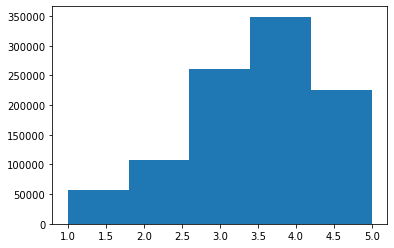

In [5]:
plt.hist(data.rating,bins=5)
plt.show()

In [6]:
data.groupby(by='rating').count()

,user_id,title,movie_id,release_date,sex,age,for_testing
rating,,,,,,,
1,56174,56174,56174,56174,56174,56174,56174
2,107557,107557,107557,107557,107557,107557,107557
3,261197,261197,261197,261197,261197,261197,261197
4,348971,348971,348971,348971,348971,348971,348971
5,226310,226310,226310,226310,226310,226310,226310


## Let's build the baselines to compare with
* TopPopular
* HighestRated

In [7]:
class TopPopRecommender(object):

    def fit(self, train):

        self.train = train
        self.movie_id2title = dict(train.groupby(by=['movie_id','title']).count().index)
        item_popularity = train[['movie_id','rating']].groupby(by='movie_id').count()

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = item_popularity.sort_values(by='rating',ascending=False).index
    
    
    def predict_top(self, user_id, at=5, remove_seen=True, return_titles = False):
    
        if remove_seen:
            seen_items = self.train[self.train.user_id==user_id].movie_id.values
            unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.popular_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]
            
        else: 
            recommended_items = self.popular_items[0:at]

        if(return_titles):
            return [self.movie_id2title[i] for i in recommended_items]
        return recommended_items
    
class HighestScoreRecommender_damped_means():

    def fit(self, train, k = 10):
        
        self.train = train
        self.movie_id2title = dict(train.groupby(by=['movie_id','title']).count().index)
        
        item_mean_ranking = train.groupby(['movie_id'])[['rating','movie_id']].agg({'rating':'mean',
                                                              'movie_id':'count'}).rename(columns = {'rating': 'mean_rating','movie_id':'num_ratings'})
        item_mean_ranking['damped_ranking'] = (item_mean_ranking['mean_rating']* item_mean_ranking['num_ratings'] + k*self.train.rating.mean()) /(item_mean_ranking['num_ratings']+k)


        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.top_items = item_mean_ranking.sort_values(by='damped_ranking',ascending=False).index    
    
    def predict_top(self, user_id, at=5, remove_seen=True, return_titles = False):

        if remove_seen:
            seen_items = self.train[self.train.user_id==user_id].movie_id.values
            unseen_items_mask = np.in1d(self.top_items, seen_items, assume_unique=True, invert = True)
            unseen_items = self.top_items[unseen_items_mask]
            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
    
        if(return_titles):
            return [self.movie_id2title[i] for i in recommended_items]
        return recommended_items

In [8]:
recTopPopular = TopPopRecommender()
recTopPopular.fit(data_train)
evaluate_algorithm_top(data_test, recTopPopular, at = 25)
recTopPopular.predict_top(1,return_titles=True)

100%|██████████████████████████████████████| 6040/6040 [00:10<00:00, 579.80it/s]

Recommender results are: Precision = 0.0814, Recall = 0.2029, MAP = 0.0705


['American Beauty (1999)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Jurassic Park (1993)',
 'Terminator 2: Judgment Day (1991)']

In [9]:
recHighestScore = HighestScoreRecommender_damped_means()
recHighestScore.fit(data_train, k = 50)
evaluate_algorithm_top(data_test, recHighestScore, at = 25)
recHighestScore.predict_top(1,return_titles=True)

100%|██████████████████████████████████████| 6040/6040 [00:10<00:00, 584.71it/s]

Recommender results are: Precision = 0.0515, Recall = 0.1297, MAP = 0.0394


['Shawshank Redemption, The (1994)',
 'Godfather, The (1972)',
 'Usual Suspects, The (1995)',
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)',
 'Raiders of the Lost Ark (1981)']

### SVD Decomposition

Singular Value Decomposition (SVD) is a well established technique for identifying latent semantic factors. Done by factorizing the user-item rating matrix.

The singular value decomposition is a methods that decomposes a matrix into three other matrices as given below:
$$ R = USV^T$$

Where
* $R$ is a $m\times n$ rating matrix;
* $U$ is a $m\times k$ orthogonal left singular matrix, which represents the relationship between users and latent factors and it is known user latent matrix;
* $S$ is a $r\times r$ diagonal matrix, whcih describes the strengh of each latent factor, and;
* $V$ is a $n \times k$ orthogonal right singular matrix, which represents the relationship between items and latent factors and it is known item latent matrix.



Columns of U and V are constrained to be mutually orthogonal. 

Mutual orthogonality has the advantage that the concepts can be completely independent of one another. Can be interpre
ted in scatterplots

**Problem**: $R$ matrix needs to be complete in order to be decomposed
* Solution: fill missing values with the mean rating of the user

In [10]:
movie_id2title = {}
for row in data_train[['movie_id','title']].drop_duplicates().values:
    movie_id2title[row[0]] = row[1]

In [11]:
from scipy import sparse
from scipy.linalg import sqrtm

class RecSys_mf():
    """ Collaborative filtering using SVD. """
    
    def __init__(self, num_components=10):
        """ Constructor """
        self.num_components=num_components
        
        
        
    def fit(self,df_train):
        """ We decompose the R matrix into to submatrices using the training data """
        
        self.train = df_train
        self.urm = pd.pivot_table(df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index ))
        self.users_id2index = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns )) 
        self.movies_id2index= dict(zip(self.urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.urm.columns))
        self.movie_id2title = dict(df_train.groupby(by=['movie_id','title']).count().index)
        
        self.pop_items = reco.train.groupby('movie_id').count()[['rating']]

        train_matrix = np.array(self.urm)
        # we mask those nan value to fill with the mean 
        mask = np.isnan(train_matrix)
        masked_arr = np.ma.masked_array(train_matrix, mask)
        item_means = np.mean(masked_arr, axis=0)

        # nan entries will replaced by the average rating for each item
        train_matrix = masked_arr.filled(item_means)
        #train_matrix = masked_arr.filled(0)
        x = np.tile(item_means, (train_matrix.shape[0],1))         

        # we remove the per item average from all entries.
        # the above mentioned nan entries will be essentially zero now
        train_matrix = train_matrix - x
        U, s, V = np.linalg.svd(train_matrix, full_matrices=False)

        # reconstruct rating matix
        S = np.diag(s[0:self.num_components])
        U = U[:,0:self.num_components]
        V = V[0:self.num_components,:]
        S_root = sqrtm(S)

        USk=np.dot(U,S_root)
        SkV=np.dot(S_root,V)
        Y_hat = np.dot(USk, SkV)
        self.Y_hat = Y_hat + x
        
    def predict_score(self, user_id, movie_id):
        
        if movie_id in self.movies_id2index:
            return self.Y_hat[self.users_id2index[user_id],self.movies_id2index[movie_id]]
        else: # in case it is a new movie 
            return 0

        
    def predict_top(self, user_id, at=5, remove_seen=True, return_titles = False):
        '''Given a user_id predict its top AT items'''
        seen_items = self.train[self.train.user_id==user_id].movie_id.values
        unseen_items = set(self.train.movie_id.values) - set(seen_items)
        predictions = [(item_id,self.predict_score(user_id,item_id)) for item_id in unseen_items]

        sorted_predictions = sorted(predictions, key=lambda x: x[1],reverse = True)[:at]
        if(return_titles):
            return [self.movie_id2title[i[0]] for i in sorted_predictions]
        return [i[0] for i in sorted_predictions]
        

In [12]:
reco = RecSys_mf(num_components=30)
reco.fit(data_train)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict_score,data_train,data_test))
#evaluate_algorithm_top(data_test, reco, at = 25)

RMSE for Collaborative Recomender: 0.9241018102498584


In [13]:
reco.predict_top(1,return_titles = True)

['Gate of Heavenly Peace, The (1995)',
 'Schlafes Bruder (Brother of Sleep) (1995)',
 'Dry Cleaning (Nettoyage à sec) (1997)',
 'Ulysses (Ulisse) (1954)',
 'Smashing Time (1967)']

### The Vanilla Matrix Factorization Model 
* Also know as **Funk SVD**
* * Despite its name, in Funk SVD, no singular value decomposition is applied.
* * https://sifter.org/simon/journal/20061211.html

A straightforward matrix factorization model maps both users and items to a joint latent factor space of dimensionality D. User-item interaction are modeled as inner products in that space
$$R = UV$$

Each item j is associated with a vector $v_j$ from $V$, and each user $i$ is associated with a vecor $u_i$ from $U$.
The resulting dot product $u_i\cdot v_j$ captures the interaction between the user $i$ and item $j$:
$$ \hat{r} = u_i\cdot v_j$$

The goal of the matrix factorization consist on finding the mapping of each item and user to factors $u_i$ and $v_j$. To do so, the minimization the of squarred error function is performed:
$$ \sum(R_{ui} - u_i\cdot v_j)^2$$

This factorization can be learnt using **only those known ratings**. We do not need to infer missing values.

![alt Amazon](https://miro.medium.com/max/4800/1*b4M7o7W8bfRRxdMxtFoVBQ.png)

In [14]:
from scipy import sparse

class RecSys_vanilla_mf(RecSys_mf):
    """ Collaborative filtering using a custom sim(u,u'). """

    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict_score(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - \
                                     self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - \
                                     self.lmbda * self.item_vecs[i,:])
                
                
    def fit(self,df_train,df_val, n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ We decompose the R matrix into to submatrices using the training data """
        self.train = df_train
        self.val = df_val
        self.urm = pd.pivot_table(df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index ))
        self.users_id2index = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns )) 
        self.movies_id2index= dict(zip(self.urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.urm.columns))
        self.movie_id2title = dict(df_train.groupby(by=['movie_id','title']).count().index)
        
        
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.mean_rating = self.train.rating.mean()
        
        self.ratings = np.float32(self.urm.fillna(0).values)
        self.n_users, self.n_items = self.urm.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))

        for epoch in range(n_epochs):
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(self.predict_score,self.train,self.train))
            self.test_rmse.append(evaluate(self.predict_score,self.train,self.val))
            
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
            
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def __plot_learning_curves__(self):
        plt.plot(self.train_rmse,'--o',label="train_error")
        plt.plot(self.test_rmse,'--o',label="test_error")
        plt.legend()
        plt.show()
        
    def predict_score(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T)
        else:
            prediction = self.mean_rating # this is a new movie
        
        return prediction
     

Epoch: 0
	Train rmse: 1.273243311990437
	Test rmse: 1.29649987990993
Epoch: 1
	Train rmse: 1.085121638546374
	Test rmse: 1.100864798079871
Epoch: 2
	Train rmse: 1.0569048047788547
	Test rmse: 1.070092004866483
Epoch: 3
	Train rmse: 1.0455002071938617
	Test rmse: 1.057328412362233
Epoch: 4
	Train rmse: 1.0446530185841596
	Test rmse: 1.0555837651315976


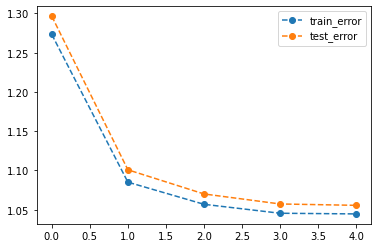

RMSE for Collaborative Recomender: 1.0555837651315976


In [15]:
reco = RecSys_vanilla_mf(num_components=5)
reco.fit(data_train,data_test, n_epochs = 5,learning_rate=0.01,lmbda=0.5)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict_score,data_train,data_test))

In [16]:
reco.predict_top(1,return_titles = True)

['Apple, The (Sib) (1998)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)',
 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)',
 'Godfather, The (1972)']

Epoch: 0
	Train rmse: 1.1235732173334956
	Test rmse: 1.1565259063168087
Epoch: 1
	Train rmse: 0.9550761071296258
	Test rmse: 0.9807482756150753
Epoch: 2
	Train rmse: 0.9267683665295965
	Test rmse: 0.9504847473602792
Epoch: 3
	Train rmse: 0.9172815203331092
	Test rmse: 0.9399199036909281
Epoch: 4
	Train rmse: 0.9112253848493437
	Test rmse: 0.9338413759508665


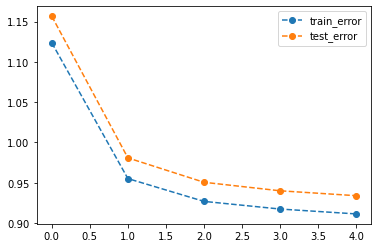

RMSE for Collaborative Recomender: 0.9338413759508665


100%|███████████████████████████████████████| 6040/6040 [05:21<00:00, 18.79it/s]

Recommender results are: Precision = 0.0210, Recall = 0.0337, MAP = 0.0071


In [17]:
reco = RecSys_vanilla_mf(num_components=5)
reco.fit(data_train,data_test, n_epochs = 5,learning_rate=0.01)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict_score,data_train,data_test))
evaluate_algorithm_top(data_test, reco, at = 25)

In [18]:
reco.predict_top(1,return_titles = True)

['Monsieur Verdoux (1947)',
 'Six-String Samurai (1998)',
 'Lodger, The (1926)',
 "Love's Labour's Lost (2000)",
 'Pather Panchali (1955)']

Epoch: 0
	Train rmse: 0.9699181945794483
	Test rmse: 0.9969532449180166
Epoch: 1
	Train rmse: 0.9355030444222862
	Test rmse: 0.958032020213569
Epoch: 2
	Train rmse: 0.9236749537884147
	Test rmse: 0.9459620274026997
Epoch: 3
	Train rmse: 0.9136002572536083
	Test rmse: 0.9373875273494178
Epoch: 4
	Train rmse: 0.907577336486922
	Test rmse: 0.9314810858150392
Epoch: 5
	Train rmse: 0.9028686273299672
	Test rmse: 0.9263535654128742
Epoch: 6
	Train rmse: 0.8987964251357395
	Test rmse: 0.9236334145605657
Epoch: 7
	Train rmse: 0.894123542884827
	Test rmse: 0.9183994372505021
Epoch: 8
	Train rmse: 0.8924268857602341
	Test rmse: 0.9171220900977075
Epoch: 9
	Train rmse: 0.890493317274383
	Test rmse: 0.9160661285358366
Epoch: 10
	Train rmse: 0.8861866396887605
	Test rmse: 0.9132500051285442
Epoch: 11
	Train rmse: 0.8830196890452976
	Test rmse: 0.9104035357577587
Epoch: 12
	Train rmse: 0.8829405831701942
	Test rmse: 0.9106241660289692
Epoch: 13
	Train rmse: 0.8793777881748351
	Test rmse: 0.907209919

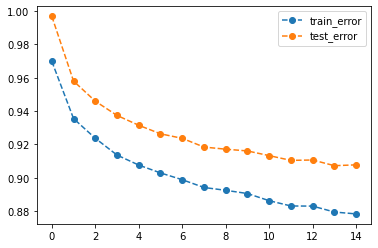

RMSE for Collaborative Recomender: 0.9077184614915994


100%|███████████████████████████████████████| 6040/6040 [05:21<00:00, 18.79it/s]

Recommender results are: Precision = 0.0302, Recall = 0.0734, MAP = 0.0089


In [19]:
reco = RecSys_vanilla_mf(num_components=5)
reco.fit(data_train,data_test, n_epochs = 15,learning_rate=0.02)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict_score,data_train,data_test))
evaluate_algorithm_top(data_test, reco, at = 25)

In [20]:
reco.predict_top(1,return_titles = True)

['Apple, The (Sib) (1998)',
 'Nénette et Boni (1996)',
 'Lamerica (1994)',
 "It's a Wonderful Life (1946)",
 'Arsenic and Old Lace (1944)']

In [21]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Lion King, The (1994)', 353),
 ('Absent Minded Professor, The (1961)', 1821),
 ('League of Their Own, A (1992)', 3012),
 ('Star Trek IV: The Voyage Home (1986)', 1269),
 ('Romancing the Stone (1984)', 2198),
 ('Erin Brockovich (2000)', 3156)]

### The Vanilla Matrix Factorization Model with biases 

* Despite its name, in SVD, no singular value decomposition is applied.


Now the model is defined as:
$\hat{r}_{ui} = \bar{r} + b_{u_u} + b_{i_i}  \sum_{k = 1}^KP_{uk} Q_{ik}^T  $

To learn the model we can use the SGD as before. Now the latent factors and biases are updated as follows:
* $error = r -\hat{r}$
* $b_{u_u} = b_{u_u} + \alpha*(error -  \lambda*b_{u_u})$
* $b_{i_i} = b_{i_i} + \alpha*(error -  \lambda*b_{i_i})$
* $P_{uk} = P_{uk} + \alpha*(error*Q_{ik} -  \lambda*P_{uk})$
* $Q_{ik} = Q_{ik} + \alpha*(error*P_{uk} -  \lambda*Q_{ik})$

where $\alpha$ is the learning rate and $\lambda$ is the regularization term.

In [22]:
from sklearn.decomposition import TruncatedSVD
from scipy import sparse

class RecSys_vanilla_mf_biases(RecSys_vanilla_mf):
                  
    def __sdg__(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            user_id = self.users[u]
            item_id = self.movies[i]
            
            prediction = self.predict_score(user_id, item_id)
            error = (self.ratings[u,i] - prediction) # error
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (error * self.item_vecs[i, :] - self.lmbda * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (error * self.user_vecs[u, :] - self.lmbda * self.item_vecs[i,:])
            
            self.bias_item[i] += self.learning_rate * (error - self.lmbda * self.bias_item[i]) 
            self.bias_user[u] += self.learning_rate * (error - self.lmbda * self.bias_user[u]) 
            
                
    def fit(self,df_train,df_val, n_epochs = 10,learning_rate =0.001,lmbda=0.1,verbose =True):
        """ Train the model. """
        self.verbose = verbose
        self.learning_rate = learning_rate
        self.lmbda = lmbda
        
        self.train = df_train
        self.val = df_val
        
        self.urm = pd.pivot_table(df_train[['user_id','movie_id','rating']],columns='movie_id',index='user_id',values='rating')
        
        # We create a dictionary where we will store the user_id and movie_id which correspond 
        # to each index in the Rating matrix
        
        user_index = np.arange(len(self.urm.index))
        self.users = dict(zip(user_index,self.urm.index ))
        self.users_id2index = dict(zip(self.urm.index,user_index)) 
        
        movie_index = np.arange(len(self.urm.columns))
        self.movies = dict(zip(movie_index,self.urm.columns )) 
        self.movies_id2index= dict(zip(self.urm.columns, movie_index))
        self.movies_index2id= dict(zip(movie_index,self.urm.columns))
        self.movie_id2title = dict(df_train.groupby(by=['movie_id','title']).count().index)
        
        
        
        self.mean_rating = self.train.rating.mean()
        
        self.ratings = np.float32(self.urm.fillna(0).values)
        self.n_users, self.n_items = self.urm.shape
        self.sample_row, self.sample_col = self.ratings.nonzero()
        self.n_samples = len(self.sample_row)
        print(self.n_samples)
        self.train_rmse =[]
        self.test_rmse = []
        iter_diff = 0
        
        # initialize latent vectors
        self.user_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,\
                                          size=(self.n_users, self.num_components))
        self.item_vecs = self.mean_rating*np.random.normal(scale=1./self.num_components,
                                          size=(self.n_items, self.num_components))
        self.bias_item = np.random.normal(scale=1/self.n_items,size=(self.n_items))
        self.bias_user = np.random.normal(scale=1/self.n_users,size=(self.n_users))
        
        
        for epoch in range(n_epochs):
    
            print('Epoch: {}'.format(epoch))
            
            self.training_indices = np.arange(self.n_samples)
            
            #shuffle training samples
            np.random.shuffle(self.training_indices)
            self.__sdg__()
            
            self.train_rmse.append(evaluate(reco.predict_score,self.train,self.train))
            self.test_rmse.append(evaluate(reco.predict_score,self.train,self.val))
            
            print('\tTrain rmse: %s' % self.train_rmse[-1])
            print('\tTest rmse: %s' % self.test_rmse[-1])
        
        if(self.verbose):
            self.__plot_learning_curves__()
    
    def predict_score(self, user_id, movie_id):
        """ Single user and item prediction."""
        user_index = self.users_id2index[user_id]
        if movie_id in self.movies_id2index:
            item_index = self.movies_id2index[movie_id]
            prediction =  self.mean_rating + self.user_vecs[user_index, :].dot(self.item_vecs[item_index, :].T) + self.bias_item[item_index] + self.bias_user[user_index]
        else:
            prediction = self.mean_rating # this is a new movie

        return prediction
    

797758
Epoch: 0
	Train rmse: 0.9137346810508039
	Test rmse: 0.9337206324088176
Epoch: 1
	Train rmse: 0.9018707327921879
	Test rmse: 0.9223133282062946
Epoch: 2
	Train rmse: 0.8983140550122115
	Test rmse: 0.9192072459290062
Epoch: 3
	Train rmse: 0.8964447516226672
	Test rmse: 0.9166236478051588
Epoch: 4
	Train rmse: 0.894716785393113
	Test rmse: 0.9153177877027868


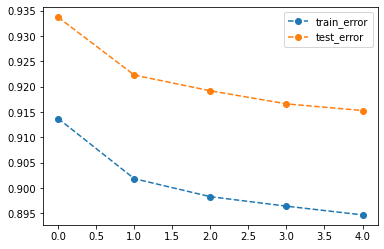

RMSE for Collaborative Recomender: 0.9153177877027868


In [23]:
reco = RecSys_vanilla_mf_biases(num_components=5)
reco.fit(data_train,data_test, n_epochs = 5,learning_rate=0.02)
print('RMSE for Collaborative Recomender: %s' % evaluate(reco.predict_score,data_train,data_test))

In [24]:
reco.predict_top(1,return_titles = True)

['Confessional, The (Le Confessionnal) (1995)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Children of Heaven, The (Bacheha-Ye Aseman) (1997)',
 'First Love, Last Rites (1997)',
 'Sanjuro (1962)']

In [25]:
evaluate_algorithm_top(data_test, reco, at = 25)

100%|███████████████████████████████████████| 6040/6040 [05:28<00:00, 18.37it/s]

Recommender results are: Precision = 0.0211, Recall = 0.0328, MAP = 0.0074


In [26]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Toy Story (1995)', 0),
 ('Apostle, The (1997)', 1546),
 ('Little Mermaid, The (1989)', 1886),
 ('Top Hat (1935)', 877),
 ('Badlands (1973)', 3478),
 ('Conversation, The (1974)', 3467)]

797758
Epoch: 0
	Train rmse: 0.9102755963769634
	Test rmse: 0.9209788271750053
Epoch: 1
	Train rmse: 0.9049037342330173
	Test rmse: 0.9174269396922596
Epoch: 2
	Train rmse: 0.903080275509091
	Test rmse: 0.9162141753983352
Epoch: 3
	Train rmse: 0.8982335444671037
	Test rmse: 0.912216163304683
Epoch: 4
	Train rmse: 0.8903641549438732
	Test rmse: 0.9059195963286761
Epoch: 5
	Train rmse: 0.8833520227465635
	Test rmse: 0.901000682728536
Epoch: 6
	Train rmse: 0.8766547228714567
	Test rmse: 0.8962372672378438
Epoch: 7
	Train rmse: 0.8713866102701135
	Test rmse: 0.8926517912285485
Epoch: 8
	Train rmse: 0.8665726993160625
	Test rmse: 0.8895738593610957
Epoch: 9
	Train rmse: 0.8607412202916921
	Test rmse: 0.8854062615427877
Epoch: 10
	Train rmse: 0.8565270022858651
	Test rmse: 0.8836733574477651
Epoch: 11
	Train rmse: 0.8523828663652254
	Test rmse: 0.8810444251343617
Epoch: 12
	Train rmse: 0.8486037633794753
	Test rmse: 0.8788223262099039
Epoch: 13
	Train rmse: 0.8450393832697337
	Test rmse: 0.8

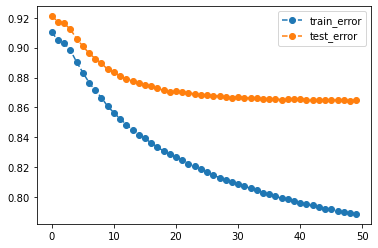

In [27]:
reco = RecSys_vanilla_mf_biases(num_components=100)
reco.fit(data_train,data_test, n_epochs = 50,learning_rate=0.02,lmbda=0.1)

In [28]:
reco.predict_top(1,return_titles = True)

['Song of Freedom (1936)',
 'Apple, The (Sib) (1998)',
 'Mamma Roma (1962)',
 'Godfather, The (1972)',
 'Lamerica (1994)']

In [29]:
from sklearn.metrics.pairwise import euclidean_distances
movie_id = 1 #'Toy Story (1995)'
#movie_id = 364 #'Lion King, The (1994)'

pairwise_distances = euclidean_distances(reco.item_vecs, reco.item_vecs)
[(reco.movie_id2title[reco.movies_index2id[item]],
  item) for item in np.argsort(pairwise_distances[reco.movies_id2index[movie_id]])[0:6]]

[('Toy Story (1995)', 0),
 ('Toy Story 2 (1999)', 2881),
 ("Bug's Life, A (1998)", 2147),
 ('Aladdin (1992)', 573),
 ('Big Combo, The (1955)', 3046),
 ('Little Mermaid, The (1989)', 1886)]

In [30]:
evaluate_algorithm_top(data_test, reco, at = 25)

100%|███████████████████████████████████████| 6040/6040 [30:04<00:00,  3.35it/s]

Recommender results are: Precision = 0.0318, Recall = 0.0896, MAP = 0.0166
